In [2]:
import torch_geometric.transforms as T
import os.path as osp
from sklearn.manifold import TSNE
import torch
import umap

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random
from scipy.integrate import simps
from matplotlib import cm
from matplotlib.patches import Ellipse
import seaborn as sns
from scipy.spatial.distance import cdist
from numpy.linalg import LinAlgError
import re

from sklearn.preprocessing import StandardScaler
from sklearn.covariance import LedoitWolf  # Import Ledoit-Wolf estimator
from sklearn.covariance import shrunk_covariance, EmpiricalCovariance
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial.distance import mahalanobis
from matplotlib.lines import Line2D
import re

2024-10-09 15:27:23.610611: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-09 15:27:23.921590: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-09 15:27:23.961912: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-09 15:27:23.961934: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

Read in data

In [3]:
window = 60 * 60

day_1_start = (8 * 60 + 30) * 60
day_1_end = (17 * 60 + 30) * 60
day_2_start = ((24 + 8) * 60 + 30) * 60
day_2_end = ((24 + 17) * 60 + 30) * 60

T1 = int((day_1_end - day_1_start) // window)
T2 = int((day_2_end - day_2_start) // window)
T = T1 + T2

print(f"Number of time windows: {T}")

# %%
fname = "ia-primary-school-proximity-attr.edges"
file = open(fname)

label_dict = {
    "1A": 0,
    "1B": 1,
    "2A": 2,
    "2B": 3,
    "3A": 4,
    "3B": 5,
    "4A": 6,
    "4B": 7,
    "5A": 8,
    "5B": 9,
    "Teachers": 10,
}
num_classes = 10

nodes = []
node_labels = []
edge_tuples = []

for line in file:
    node_i, node_j, time, id_i, id_j = line.strip("\n").split(",")

    if day_1_start <= int(time) < day_1_end:
        t = (int(time) - day_1_start) // window
    elif day_2_start <= int(time) < day_2_end:
        t = T1 + (int(time) - day_2_start) // window
    else:
        continue

    if node_i not in nodes:
        nodes.append(node_i)
        node_labels.append(label_dict[id_i])

    if node_j not in nodes:
        nodes.append(node_j)
        node_labels.append(label_dict[id_j])

    edge_tuples.append([t, node_i, node_j])

edge_tuples = np.unique(edge_tuples, axis=0)
nodes = np.array(nodes)

n = len(nodes)
print(f"Number of nodes: {n}")

node_dict = dict(zip(nodes[np.argsort(node_labels)], range(n)))
node_labels = np.sort(node_labels)

# %% [markdown]
# Create a list of adjacency matrices.

# %%
As = np.zeros((T, n, n))

for m in range(len(edge_tuples)):
    t, i, j = edge_tuples[m]
    As[int(t), node_dict[i], node_dict[j]] = 1
    As[int(t), node_dict[j], node_dict[i]] = 1

Number of time windows: 18
Number of nodes: 242


In [4]:
# Format the data to work with existing code
labels = node_labels

# just look at first (whatever is specified) timepoint
dense_adj = As[1]

In [5]:
# just 4 classes!
startnode = 142 
endnode = 231

dense_adj = dense_adj[startnode:endnode+1, startnode:endnode+1]

dense_adj = np.matrix(dense_adj)

node_labels = node_labels[startnode:endnode+1]
labels = node_labels

In [7]:
k = 3
B = 30
d = 2

## Standardise so plots are mean 0, sd 1

In [8]:
# obs_adj is the observed adjacency matrix
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

p_vals = []
A_boots_list = []

for b in tqdm(range(B)):
    p_val, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

print(f"B={B}, d={d}, k={k}")


100%|██████████| 30/30 [00:05<00:00,  5.19it/s]

B=30, d=2, k=3


In [9]:
A_list = [dense_adj] + A_boots_list
len(A_list)

yhat = UASE(A_list, d=d, sparse_matrix=False)

In [10]:
yadf = pd.DataFrame(yhat)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = np.tile(node_labels, B + 1)

# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(B+1), len(labels))

# repeat range(len(node_labels)) B+1 times to give each node a unique number
yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)

### B=20 and perplexity=30 make plots

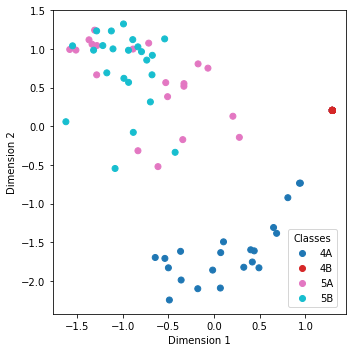

In [11]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(5,5))

yhat_A = UASE([dense_adj], d=d, sparse_matrix=False)
yadf_A = pd.DataFrame(yhat_A)

# rename the columns - this is called a list comprehension
yadf_A.columns = ["Dimension_{}".format(i+1) for i in range(yadf_A.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf_A["tau"] = np.tile(node_labels, 1)

# repeat range(len(node_labels)) B+1 times to give each node a unique number
yadf_A['NodeNumber'] = list(range(len(node_labels)))

# Standardize the data in the Dimension_1 and Dimension_2 columns - so Dimension_1 and Dimension_2 have mean 0 and standard deviation 1
scaler = StandardScaler()
# Fit the scaler on the Dimension columns and transform them
# Aobs_yadf[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(Aobs_yadf[["Dimension_1", "Dimension_2"]])
yadf_A[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(yadf_A[["Dimension_1", "Dimension_2"]])

# Plot the scatter plot
scatter = ax.scatter(yadf_A["Dimension_1"], yadf_A["Dimension_2"], c=yadf_A["tau"], cmap='tab10')
# plot tau=7 in red
ax.scatter(yadf_A[yadf_A["tau"] == 7]["Dimension_1"], yadf_A[yadf_A["tau"] == 7]["Dimension_2"], c='#d62728', label='tau=7')

ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  # Inverse mapping
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv.get(numeric_label, "Unknown"))

# Add the legend with the mapped labels
fig.legend(handles, mapped_labels, title="Classes", loc="lower right", bbox_to_anchor=(0.96, 0.12))

# Adjust layout to make room for titles and labels
plt.tight_layout()

# plt.savefig("figs/school_A1_embed_A_sd1mean0_4classes.png", bbox_inches='tight', facecolor='white')

# Show the combined plot
plt.show()

pick out a node and show knn of it

Node 13.0: [-0.1590071  -0.27928045]
Node 12.0: [-0.17861409 -0.34423443]
Node 6.0: [-0.11871598 -0.30329837]


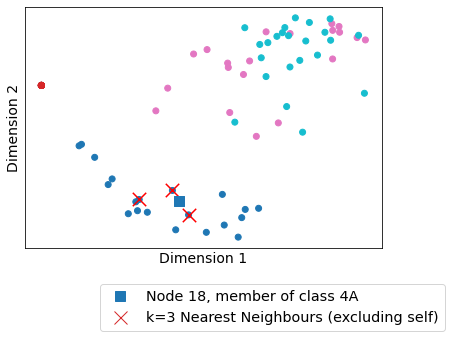

In [13]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(5.5,3.9))

Aobs_yadf = yadf[yadf["Matrix"] == 0]
# first two dimensions in an array
Aobs_array = Aobs_yadf.iloc[:, 0:2].to_numpy()

node_number = 18
k = 3
Aobs_yadf_node = Aobs_yadf[Aobs_yadf["NodeNumber"] == node_number]

# Filter data for node number and select the relevant dimensions
data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

# Plot the scatter plot
scatter = ax.scatter(Aobs_yadf["Dimension_1"], Aobs_yadf["Dimension_2"], c=Aobs_yadf["tau"], cmap='tab10')
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 2", fontsize=14)

# no ticks
ax.set_xticks([])
ax.set_yticks([])

# Find the k-nearest neighbors
nbrs = NearestNeighbors(n_neighbors=k+1).fit(Aobs_array)  # +1 to include the node itself
distances, indices = nbrs.kneighbors(data_d_dim[:, :2])

# Get the k-nearest neighbors excluding the node itself
nearest_neighbors = indices[0][1:]

# Output the k-nearest neighbors
# print(f"{k} nearest neighbors of node {node_number}:")

for idx in nearest_neighbors:
    point = Aobs_array[idx]
    node = Aobs_yadf.iloc[idx]["NodeNumber"]
    print(f"Node {node}: {point}")
    # Plot the point with an 'x' marker
    ax.scatter(point[0], point[1], color='red', marker='x', s=180)
    # Annotate the point with the node number, rounded to integers
    # ax.annotate(str(int(node)), (point[0], point[1]), textcoords="offset points", xytext=(5,5), ha='center')

# Create custom second legend
legend_elements = [
    Line2D([0], [0], color='#1f77b4',  marker='s', lw=0, label=f'Node {node_number}, member of class 4A', markerfacecolor='#1f77b4', markersize=10),  
    Line2D([0], [0], color='#d62728', marker='x', lw=0, label=f'k={k} Nearest Neighbours (excluding self)', markersize=13, markerfacecolor='#e377c2')  
]

fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15,0.), fontsize='x-large', ncol=1)

# plot the point for node with node_number in blue
ax.scatter(Aobs_yadf_node["Dimension_1"], Aobs_yadf_node["Dimension_2"], color='#1f77b4', label=f'Node {node_number}, member of class 4A', marker='s', s=100)

# plot the class 4B in red
ax.scatter(Aobs_yadf[Aobs_yadf["tau"] == 7]["Dimension_1"], Aobs_yadf[Aobs_yadf["tau"] == 7]["Dimension_2"], c='#d62728', label='tau=7')

#invert x axis
ax.invert_xaxis()

# # get rid of box around plot
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# Adjust layout to make room for titles and labels
plt.tight_layout()

# plt.savefig(f"figs/school_A1_embedA_viaUASE_sd1mean0_4classes_node{node_number}_knn{k}_noaxes.png", bbox_inches='tight', facecolor='white')

# Show the combined plot
plt.show()

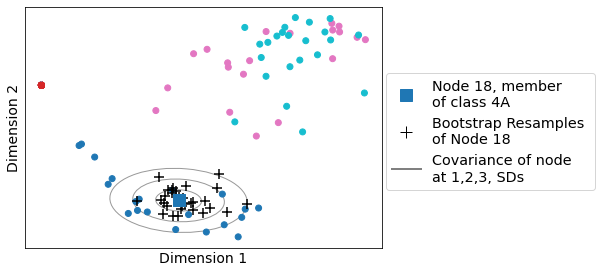

In [16]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(5.5, 3.9))

Aobs_yadf = yadf[yadf["Matrix"] == 0]
# first two dimensions in an array
Aobs_array = Aobs_yadf.iloc[:, 0:2].to_numpy()

node_number = 18

Aobs_yadf_node = Aobs_yadf[Aobs_yadf["NodeNumber"] == node_number]

# Filter data for node number and select the relevant dimensions
data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

# Calculate the covariance considering all d dimensions
cov_d_dim = np.cov(data_d_dim, rowvar=False)

# plot the covariance ellipse with the same color as the point
plot_ellipse_3mahals(ax, data_d_dim[0, 0:2], cov_d_dim[0:2, 0:2], color='#808080', lw=1)

# Plot the scatter plot
scatter = ax.scatter(Aobs_yadf["Dimension_1"], Aobs_yadf["Dimension_2"], c=Aobs_yadf["tau"], cmap='tab10')
ax.set_xlabel("Dimension 1", fontsize=14)
ax.set_ylabel("Dimension 2", fontsize=14)

#no ticks
ax.set_xticks([])
ax.set_yticks([])

# Plot the bootstrap points
ax.scatter(data_d_dim[:, 0], data_d_dim[:, 1], color='black', alpha=1, marker='+', s=100)

# Create custom second legend
legend_elements = [
    Line2D([0], [0], color='#1f77b4', marker='s', lw=0, label=f'Node {node_number}, member \nof class 4A', markersize=12, markerfacecolor='#1f77b4'),
    Line2D([0], [0], color='black', marker='+', lw=0, label=f'Bootstrap Resamples \nof Node {node_number}', markersize=12, markerfacecolor='#e377c2'),
    Line2D([0], [0], color='#808080', lw=2, label='Covariance of node \nat 1,2,3, SDs', linestyle='-')
]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.53, 0.75), fontsize='x-large', ncol=1, title_fontsize='large')

# plot the point for node with node_number in blue square
ax.scatter(Aobs_yadf_node["Dimension_1"], Aobs_yadf_node["Dimension_2"], color='#1f77b4', label=f'Node {node_number}, member of class 4A', marker='s', s=130)  # Increase marker size

# plot the class 4B in red
ax.scatter(Aobs_yadf[Aobs_yadf["tau"] == 7]["Dimension_1"], Aobs_yadf[Aobs_yadf["tau"] == 7]["Dimension_2"], c='#d62728', label='tau=7')

# invert x axis
ax.invert_xaxis()

# Adjust layout to make room for titles and labels
plt.tight_layout()

plt.savefig(f"figs/school_A1_embedA_viaUASE_sd1mean0_4classes_node{node_number}_boostraps_3mahals_noaxes.png", bbox_inches='tight', facecolor='white')

# Show the combined plot
plt.show()

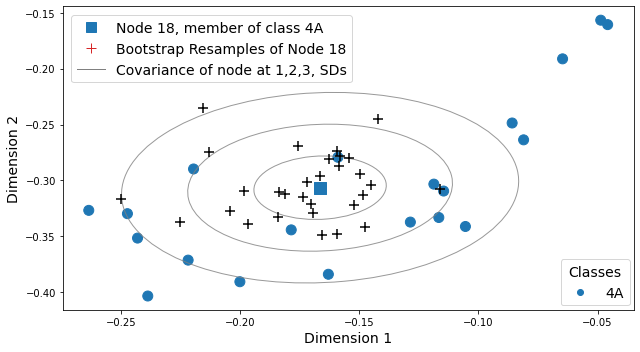

In [17]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(9,5))  # Increase figure size for better readability

Aobs_yadf = yadf[yadf["Matrix"] == 0]
# first two dimensions in an array
Aobs_array = Aobs_yadf.iloc[:, 0:2].to_numpy()

node_number = 18
zoom_range = 0.15  # Define the range around node 18 for zooming in

Aobs_yadf_node = Aobs_yadf[Aobs_yadf["NodeNumber"] == node_number]
node_18_coords = Aobs_yadf_node.iloc[0, 0:2].to_numpy()

# Filter data to include only points within the zoom range around node 18
zoom_mask = np.all(np.abs(Aobs_array - node_18_coords) <= zoom_range, axis=1)
Aobs_yadf_zoom = Aobs_yadf[zoom_mask]
Aobs_array_zoom = Aobs_array[zoom_mask]

# Plot the scatter plot for the zoomed-in data
scatter = ax.scatter(Aobs_yadf_zoom["Dimension_1"], Aobs_yadf_zoom["Dimension_2"], c=Aobs_yadf_zoom["tau"], cmap='tab10', s=100)  # Increase marker size
ax.set_xlabel("Dimension 1", fontsize=14)  # Increase font size
ax.set_ylabel("Dimension 2", fontsize=14)  # Increase font size

# plot the covariance ellipse with the same color as the point
plot_ellipse_3mahals(ax, data_d_dim[0, 0:2], cov_d_dim[0:2, 0:2], color='#808080', lw=1)


# Plot the bootstrap points
ax.scatter(data_d_dim[:, 0], data_d_dim[:, 1], color='black', alpha=1, marker='+', s=100)  # Increase marker size

# Add legend for classes, mapping the integer labels back to the label_dict keys
handles, labels_legend = scatter.legend_elements()
label_dict_inv = {v: k for k, v in label_dict.items()}  # Inverse mapping
mapped_labels = []
for label in labels_legend:
    match = re.search(r'\d+', label)
    if match:
        numeric_label = int(match.group(0))
        mapped_labels.append(label_dict_inv.get(numeric_label, "Unknown"))

# Add the legend with the mapped labels
fig.legend(handles, mapped_labels, title="Classes", loc="lower left", bbox_to_anchor=(0.86, 0.12), ncols=1, fontsize=14, title_fontsize=14)  # Increase font size

# Create custom second legend
legend_elements = [
    Line2D([0], [0], color='#1f77b4', marker='s', lw=0, label=f'Node {node_number}, member of class 4A', markersize=10, markerfacecolor='#1f77b4'),
    Line2D([0], [0], color='#d62728', marker='+', lw=0, label=f'Bootstrap Resamples of Node {node_number}', markersize=10, markerfacecolor='#e377c2'),
    Line2D([0], [0], color='#808080', lw=1, label='Covariance of node at 1,2,3, SDs', linestyle='-')
]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.56, 0.965), fontsize=14, title_fontsize=14)  # Increase font size

# plot the point for node with node_number in blue square
ax.scatter(Aobs_yadf_node["Dimension_1"], Aobs_yadf_node["Dimension_2"], color='#1f77b4', label=f'Node {node_number}, member of class 4A', marker='s', s=150)  # Increase marker size

# plot the class 4B in red
ax.scatter(Aobs_yadf_zoom[Aobs_yadf_zoom["tau"] == 7]["Dimension_1"], Aobs_yadf_zoom[Aobs_yadf_zoom["tau"] == 7]["Dimension_2"], c='#d62728', label='tau=7', s=100)  # Increase marker size

# Adjust layout to make room for titles and labels
plt.tight_layout()

# plt.savefig(f"figs/school_A1_embedA_viaUASE_sd1mean0_4classes_node{node_number}_boostraps_3mahals_zoom.png", bbox_inches='tight', facecolor='white')

# Show the combined plot
plt.show()

#### Plot A[1] adjacency matrix

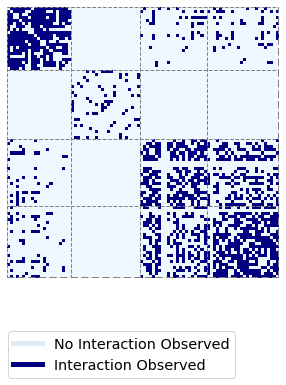

In [182]:
# Define blue hex codes for the colormap
blue_colors = ["#f0f8ff", "#add8e6", "#87ceeb", "#4682b4", 
               "#4169e1", "#0000ff", "#0000cd",  "#000080"]

# Create a custom colormap
blues_cmap = LinearSegmentedColormap.from_list("blues_cmap", blue_colors)


# Replace labels using label_dict_inv
mapped_labels = [label_dict_inv[label] for label in labels]

# Initialize a list to store the positions where the value changes
change_positions = [0]

# Loop through the list and find where the value changes
for i in range(1, len(mapped_labels)):
    if mapped_labels[i] != mapped_labels[i-1]:
        change_positions.append(i)  # Store the position of the change

# add on the last place for a change position - so that the teachers will get a label
change_positions.append(len(labels)-1)

# Get the corresponding labels for those positions
change_labels = [mapped_labels[i] for i in change_positions]

# Get the corresponding labels for the middle of each section
middle_positions = [(change_positions[i] + change_positions[i+1]) / 2 for i in range(len(change_positions) - 1)]
middle_labels = [mapped_labels[change_positions[i]] for i in range(len(change_positions) - 1)]

plt.figure(figsize=(5,5))  

# Plot heatmap with the updated labels
sns.heatmap(dense_adj, square=True, cmap=blues_cmap, cbar=False) # "Blues"

# Add gridlines at the change positions
for pos in change_positions[:-1]:
    plt.axvline(x=pos, color='grey', linestyle='--', linewidth=1)  # Vertical gridlines
    plt.axhline(y=pos, color='grey', linestyle='--', linewidth=1)  # Horizontal gridlines
# at end of plot too
plt.axvline(x=90, color='grey', linestyle='--', linewidth=2)  # Vertical gridlines
plt.axhline(y=90, color='grey', linestyle='--', linewidth=2)  # Horizontal gridlines

# remove all ticks
plt.xticks([])
plt.yticks([])

# Create a custom legend
legend_labels = ['No Interaction Observed', 'Interaction Observed']
legend_colors = ['#deebf7', '#000080']  # Colors corresponding to 0 (white) and 1 (blue)

# Add the legend to the plot
for color, label in zip(legend_colors, legend_labels):
    plt.plot([], [], color=color, label=label, linewidth=5)  # Add an empty plot for legend entries
# Adjust the position of the legend below the plot
plt.legend(
    # title='Connection Status', 
    loc='center', bbox_to_anchor=(0.42, -0.28), ncol=1, fontsize='x-large', frameon=True)

# plt.title('Adjacency Matrix of Primary School Interaction \n Network at 9:00-10:00 of Day 1', fontsize=12, pad=10)

# plt.savefig('figs/adjacency_matrix_A1_heatmap_blueCustom_4classes_noaxes.png', dpi=300, bbox_inches='tight', facecolor='white')

# Show the plot
plt.show()

#### plot $\hat{P}$

In [129]:
n = dense_adj.shape[0]
A_obs = dense_adj.copy()

d=12
k=3

# Embed the graphs -------------------------------
yhat = UASE([A_obs], d=d, flat=True)

# run a k-NN on the embedding yhat
# Here we use Minkowski distance, with p=2 (these are the defaults),
# which corresponds to Euclidean distance
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(
    n_neighbors=k, algorithm="ball_tree", metric="minkowski", p=2
).fit(yhat)
distances, indices = nbrs.kneighbors(yhat)

# Estimate the P matrix -------------------------------
P_est = P_est_from_A_obs(n, A_obs, n_neighbors=k, indices=indices)

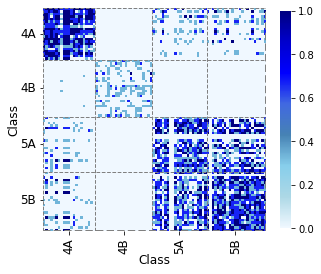

In [152]:
plt.figure(figsize=(5,5))  

# Plot heatmap with the updated labels
sns.heatmap(P_est, square=True, cmap=blues_cmap, cbar=True, cbar_kws={"shrink": 0.8})

# Add gridlines at the change positions
for pos in change_positions[:-1]:
    plt.axvline(x=pos, color='grey', linestyle='--', linewidth=1)  # Vertical gridlines
    plt.axhline(y=pos, color='grey', linestyle='--', linewidth=1)  # Horizontal gridlines
plt.axvline(x=90, color='grey', linestyle='--', linewidth=2)  # Vertical gridlines
plt.axhline(y=90, color='grey', linestyle='--', linewidth=2)  # Horizontal gridlines

# Set the xticks and yticks to the middle of the gridlines
plt.xticks(middle_positions, middle_labels, rotation=90, fontsize=12)
plt.yticks(middle_positions, middle_labels, rotation=0, fontsize=12)

plt.ylabel('Class', labelpad=0, fontsize=12)
plt.xlabel('Class', labelpad=0, fontsize=12)

# plt.title('Adjacency Matrix of Primary School Interaction \n Network at 9:00-10:00 of Day 1', fontsize=12, pad=10)

# plt.savefig('figs/Phat_matrix_A1_heatmap_blueCustom_4classes.png', dpi=300, bbox_inches='tight', facecolor='white')

# Show the plot
plt.show()

#### Embed the 4 class data into 2-D via t-SNE

In [20]:
n=dense_adj.shape[0]
n

90

100%|██████████| 20/20 [00:00<00:00, 95.80it/s]


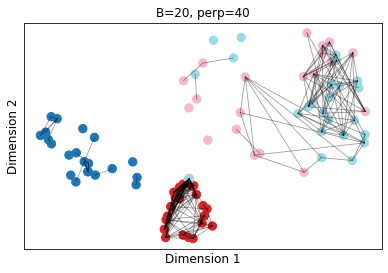

In [29]:
# Set the perplexity value
perp_val = 40

# tSNE Aobs
tsne = TSNE(n_components=2, perplexity=perp_val, random_state=0)
# tSNE the embedding of just the true adjacency matrix
A_tsne = tsne.fit_transform(dense_adj)

# Convert to DataFrame
A_tsne_df = pd.DataFrame(A_tsne)
A_tsne_df.columns = ["Dimension_{}".format(i+1) for i in range(A_tsne_df.shape[1])]
A_tsne_df["tau"] = np.tile(node_labels, 1)

# Standardize the data in the Dimension_1 and Dimension_2 columns
scaler = StandardScaler()
A_tsne_df[["Dimension_1", "Dimension_2"]] = scaler.fit_transform(A_tsne_df[["Dimension_1", "Dimension_2"]])

# Assume B=20 and other required variables like 'yhat', 'node_labels', 'in_cov_friends_symm' are already defined.
B = 20

A_boots_list = []

for b in tqdm(range(B)):
    _, A_boots = create_single_kNN_bootstrap(dense_adj, d=d, Q=1000, n_neighbors=k)
    A_boots_list.append(A_boots)

A_list = [dense_adj] + A_boots_list
yhat = UASE(A_list, d=d, sparse_matrix=False)

yadf = pd.DataFrame(yhat)

# Rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# Repeat tau list the length of A_true_boots_list times
yadf["tau"] = np.tile(node_labels, B + 1)

# Add column for the matrix it is
yadf["Matrix"] = np.repeat(range(B+1), len(node_labels))

# Repeat range(len(node_labels)) B+1 times to give each node a unique number
yadf['NodeNumber'] = list(range(len(node_labels)))*(B+1)


""""Create the new uncertainty adjacency matrix using this many B bootstraps"""
in_cov_friends = np.zeros((n, n))

for i in range(n):
    # Filter data for node number and select the relevant dimensions
    node_number = i
    data_d_dim = yadf[yadf["NodeNumber"] == node_number].iloc[:, 0:d].to_numpy()

    # Calculate the mean and covariance considering all d dimensions
    mean_d_dim = np.mean(data_d_dim, axis=0)
    cov_d_dim = np.cov(data_d_dim, rowvar=False)

    # Use the point corresponding to the specific node_number in matrix 0 as the center
    point = data_d_dim[0]
    obs_points = yadf[yadf["Matrix"] == 0].iloc[:, 0:d].to_numpy()

    # Plotting only the first two dimensions
    data_2d = data_d_dim[:, 0:2]
    obs_points_2d = obs_points[:, 0:2]

    # Filter points within the ellipse
    inside_ellipse = points_within_ellipse(obs_points_2d, point[:2], cov_d_dim[:2, :2])

    # Extract node numbers for points inside the ellipse
    node_numbers_inside_ellipse = yadf[yadf["Matrix"] == 0].iloc[inside_ellipse].index.tolist()

    # Set in_cov_friends[i, node_numbers_inside_ellipse] = 1
    in_cov_friends[i, node_numbers_inside_ellipse] = 1

# Symmetrize the matrix in_cov_friends
in_cov_friends_symm = np.minimum(in_cov_friends, in_cov_friends.T)

# Plot the scatter plot
fig, ax = plt.subplots(figsize=(5.5, 3.9))
scatter = ax.scatter(A_tsne_df["Dimension_1"], A_tsne_df["Dimension_2"], c=A_tsne_df["tau"], cmap='tab20', s=70, alpha=1)  # Increase marker size
ax.set_xlabel("Dimension 1", fontsize=12)
ax.set_ylabel("Dimension 2", fontsize=12)

#  no ticks
ax.set_xticks([])
ax.set_yticks([])

# Draw lines between connected nodes based on the F matrix
for i in range(len(A_tsne_df)):
    for j in range(i + 1, len(A_tsne_df)):
        if in_cov_friends_symm[i, j] == 1:  # Check if nodes i and j are connected
            ax.plot([A_tsne_df["Dimension_1"].iloc[i], A_tsne_df["Dimension_1"].iloc[j]], 
                    [A_tsne_df["Dimension_2"].iloc[i], A_tsne_df["Dimension_2"].iloc[j]], 
                    'k-', lw=0.8, alpha=0.4)  # Draw a line between them
            
plt.title(f"B={B}, perp={perp_val}")

plt.tight_layout()

plt.savefig(f"figs/school_A1_tsne_4classes_perp30_B20_plot_tsne(A)_B{B}_perp{perp_val}.png", bbox_inches='tight', facecolor='white')

plt.show()

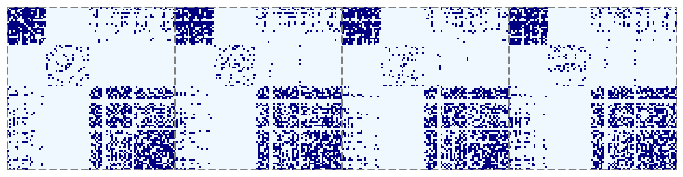

In [56]:
reshaped_A = np.hstack(A_list[0:4])

plt.figure(figsize=(12,3))  # Set figure size as needed

sns.heatmap(reshaped_A, cmap=blues_cmap, cbar=False) # "Blues"

matrix_positions = [0, dense_adj.shape[0], 2 * dense_adj.shape[0], 3 * dense_adj.shape[0], 4 * dense_adj.shape[0]]

# Add gridlines at the change positions
for pos in matrix_positions:
    plt.axvline(x=pos, color='grey', linestyle='--', linewidth=2)  # Vertical gridlines
    plt.axhline(y=pos, color='grey', linestyle='--', linewidth=2)  # Horizontal gridlines

# Disable x and y ticks
plt.xticks([])  # Remove x ticks
plt.yticks([])  # Remove y ticks

# plt.savefig("figs/school_A1_Aboots_heatmap_blueCustom_4classes_4mats.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()